# Bayesian Latent Variable Modeling for Carbon Sustainability Performance

The csv file to be mapped is named as EU Composite Dataset.csv and is present in Final Datasets folder in the Zip file

## Importing necessary Libraries

In [228]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [229]:
!pip install pymc arviz --quiet

In [230]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
import plotly.express as px
from sklearn.preprocessing import MinMaxScaler

In [231]:
import pymc as pm
import arviz as az
import seaborn as sns
import matplotlib.pyplot as plt

In [232]:
from sklearn.mixture import BayesianGaussianMixture

## Data Preprocessing

In [233]:
df  = pd.read_csv("/content/drive/MyDrive/Clustering CBM+SDG/EU Composite Dataset.csv")
df.head(), df.columns.tolist()

(   Country  Year  Domestic Aviation  Ground Transport   Industry  \
 0  Austria  2019           0.052956         24.289183  20.204606   
 1  Austria  2020           0.043006         24.062859  19.251314   
 2  Austria  2021           0.053115         23.814914  24.915473   
 3  Austria  2022           0.032175         23.538949  24.193196   
 4  Belgium  2019           0.007597         24.653963  26.756724   
 
    International Aviation      Power  Residential  Total_MtCO2  \
 0                2.852046  14.024953     8.880186    70.303931   
 1                1.018447  12.556342     9.019489    65.951457   
 2                1.169484  12.950656     9.759080    72.662722   
 3                1.998732  14.117581     8.826311    72.706944   
 4                4.351530  18.312414    24.641355    98.723583   
 
    Energy_consumption  Renewable_Share  GDP_Capita  Passenger_transport  \
 0               753.0           33.755     45730.0                  9.7   
 1               781.0      

In [234]:
# --- Step 1: Select columns and standardize ---
selected_columns = [
    'Total_MtCO2', 'Energy_consumption', 'Renewable_Share',
    'GDP_Capita', 'Passenger_transport', 'Air_emission_intensity',
    'Grossvalue_Egoods', 'Climate_Losses', 'Climate_Spending', 'Green_Bonds'
]

# Drop rows with missing values
df_clean = df.dropna(subset=selected_columns).copy()

# Standardize
scaler = StandardScaler()
X_scaled = scaler.fit_transform(df_clean[selected_columns])

# Prepare input matrix and metadata
X = X_scaled
n_samples, n_indicators = X.shape
df_model = df_clean[['Country', 'Year']].copy()
df_model[selected_columns] = X_scaled

Output()

ERROR:pymc.stats.convergence:The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


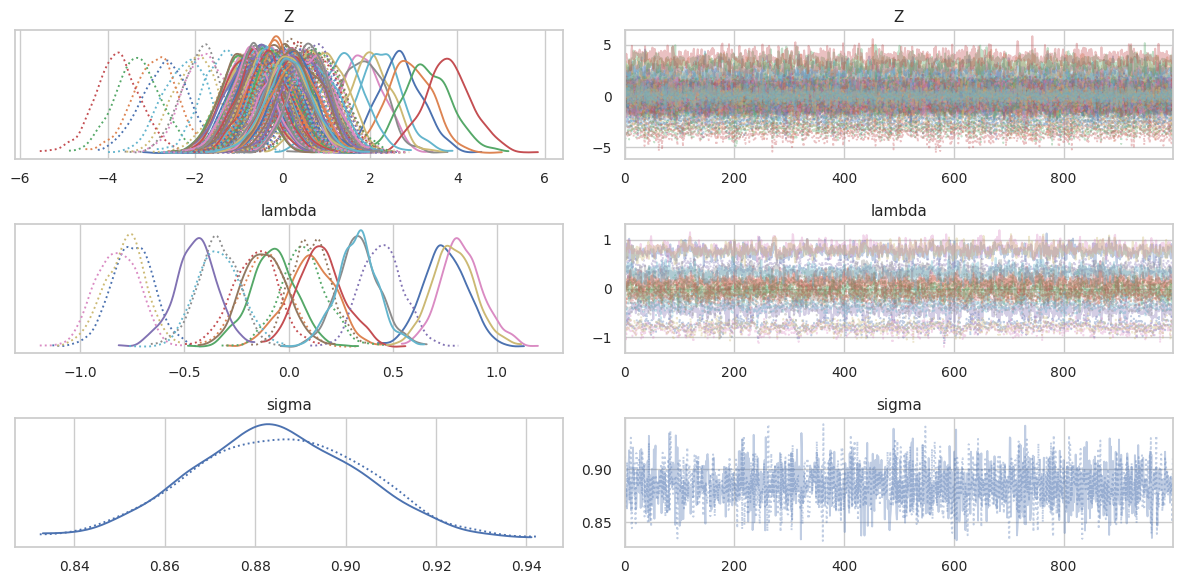

In [235]:
# --- Step 2: Bayesian Latent Variable Model ---
with pm.Model() as lvm_model:
    Z = pm.Normal("Z", mu=0, sigma=1, shape=n_samples)                  # Latent index
    lambda_ = pm.Normal("lambda", mu=0, sigma=1, shape=n_indicators)    # Factor loadings
    sigma = pm.HalfNormal("sigma", sigma=1)                             # Observation noise
    mu = pm.Deterministic("mu", Z[:, None] * lambda_)                   # Linear model
    X_obs = pm.Normal("X_obs", mu=mu, sigma=sigma, observed=X)          # Likelihood

    # Sampling
    trace = pm.sample(1000, tune=1000, target_accept=0.95, return_inferencedata=True, random_seed=42)

# Optional: Check convergence and traces
az.plot_trace(trace, var_names=["Z", "lambda", "sigma"])
plt.tight_layout()
plt.show()

In [236]:
# --- Step 3: Extract Posterior Mean of Z ---
Z_mean = trace.posterior["Z"].mean(dim=["chain", "draw"]).values.flatten()
lambda_mean = trace.posterior["lambda"].mean(dim=["chain", "draw"]).values.flatten()

# --- Step 4: Fix Sign Ambiguity ---
key_feature_index = selected_columns.index("Renewable_Share")
sign = np.sign(lambda_mean[key_feature_index])
Z_mean_fixed = sign * Z_mean  # Flip Z if needed

# --- Step 5: Normalize CSI to [0, 1] ---
Z_scaled = MinMaxScaler().fit_transform(Z_mean_fixed.reshape(-1, 1)).flatten()
df_model["Carbon_Sustainability_Index"] = Z_scaled

# Optional: View results
print(df_model[["Country", "Year", "Carbon_Sustainability_Index"]].head())


   Country  Year  Carbon_Sustainability_Index
0  Austria  2019                     0.779863
1  Austria  2020                     0.500838
2  Austria  2021                     0.631688
3  Austria  2022                     0.454812
4  Belgium  2019                     0.253593


In [237]:
# Loading the dataframe (simulating df_model as placeholder)
# df_model already contains 'Country', 'Year', and 'Carbon_Sustainability_Index'
df_fig = df_model.copy()

# Creating a choropleth map with a slider for year
fig = px.choropleth(
    df_fig,
    locations="Country",
    locationmode="country names",
    color="Carbon_Sustainability_Index",
    hover_name="Country",
    animation_frame="Year",
    color_continuous_scale="Viridis",
    title="Carbon Sustainability Index (CSI) Across Europe Over Time",
)

fig.update_layout(geo=dict(scope="europe",showframe=False, showcoastlines=True))
fig.show()


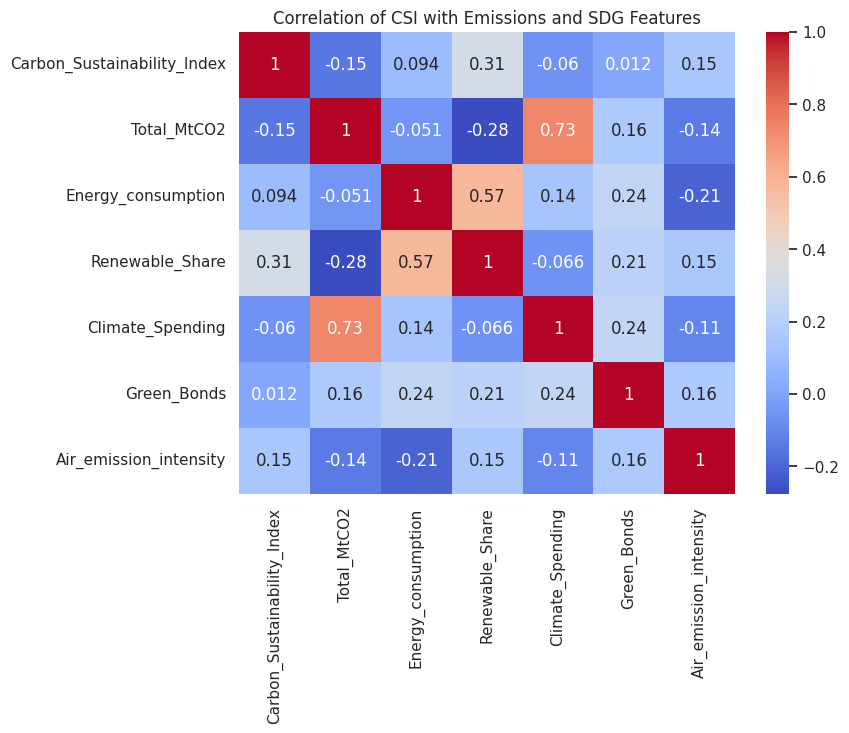

In [238]:
# Correlation matrix
correlations = df_model[[
    'Carbon_Sustainability_Index',
    'Total_MtCO2',
    'Energy_consumption',
    'Renewable_Share',
    'Climate_Spending',
    'Green_Bonds',
    'Air_emission_intensity'
]].corr()

# Heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(correlations, annot=True, cmap='coolwarm')
plt.title("Correlation of CSI with Emissions and SDG Features")
plt.show()


In [239]:
df_clean # The cleaned version of our dataset

,Country,Year,Domestic Aviation,Ground Transport,Industry,International Aviation,Power,Residential,Total_MtCO2,Energy_consumption,Renewable_Share,GDP_Capita,Passenger_transport,Air_emission_intensity,Grossvalue_Egoods,Climate_Losses,Climate_Spending,Green_Bonds
0,Austria,2019,0.052956,24.289183,20.204606,2.852046,14.024953,8.880186,70.303931,753.0,33.755,45730.0,9.7,0.04,17021.48,47.20,332.82,2.40
1,Austria,2020,0.043006,24.062859,19.251314,1.018447,12.556342,9.019489,65.951457,781.0,36.545,42650.0,9.0,0.04,16368.20,45.88,257.95,1.61
2,Austria,2021,0.053115,23.814914,24.915473,1.169484,12.950656,9.759080,72.662722,866.0,34.792,44520.0,9.1,0.04,17181.54,48.13,248.61,2.96
3,Austria,2022,0.032175,23.538949,24.193196,1.998732,14.117581,8.826311,72.706944,762.0,34.075,46350.0,8.4,0.04,18634.79,48.46,401.29,8.45
4,Belgium,2019,0.007597,24.653963,26.756724,4.351530,18.312414,24.641355,98.723583,653.0,9.929,42400.0,10.4,0.11,7957.43,12.64,99.71,0.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
115,Switzerland,2022,0.089589,15.339359,8.361359,3.989559,2.511740,12.974229,43.265835,0.0,0.000,80600.0,6.3,0.02,22361.48,52.58,0.00,0.00
116,United Kingdom,2019,1.607838,113.701374,61.230932,32.870973,76.703697,85.838166,371.952980,571.0,0.000,0.8,5.6,0.00,0.00,0.00,0.00,0.00
117,United Kingdom,2020,0.859707,104.289503,62.382029,13.360728,62.675492,83.823467,327.390926,0.0,0.000,0.0,0.0,0.00,0.00,0.00,0.00,0.00
118,United Kingdom,2021,1.153241,115.302050,65.315044,12.066851,71.492882,86.888328,352.218396,0.0,0.000,0.0,0.0,0.00,0.00,0.00,0.00,0.00


In [240]:
df_model # Scaled features + the CSI value

,Country,Year,Total_MtCO2,Energy_consumption,Renewable_Share,GDP_Capita,Passenger_transport,Air_emission_intensity,Grossvalue_Egoods,Climate_Losses,Climate_Spending,Green_Bonds,Carbon_Sustainability_Index
0,Austria,2019,-0.252175,0.952278,0.583531,0.492150,0.013746,-0.365314,0.236374,0.881859,-0.157614,-0.273085,0.779863
1,Austria,2020,-0.282034,1.079471,0.757988,0.360833,-0.161203,-0.365314,0.200178,0.818331,-0.198935,-0.445090,0.500838
2,Austria,2021,-0.235993,1.465591,0.648374,0.440562,-0.136210,-0.365314,0.245243,0.926618,-0.204090,-0.151158,0.631688
3,Austria,2022,-0.235690,0.993162,0.603540,0.518584,-0.311160,-0.365314,0.325763,0.942500,-0.119826,1.044168,0.454812
4,Belgium,2019,-0.057208,0.498019,-0.906295,0.350175,0.188695,-0.225001,-0.265840,-0.781433,-0.286269,-0.795632,0.253593
...,...,...,...,...,...,...,...,...,...,...,...,...,...
115,Switzerland,2022,-0.437664,-2.468292,-1.527150,1.978846,-0.836007,-0.405403,0.532249,1.140786,-0.341299,-0.795632,0.410845
116,United Kingdom,2019,1.817224,0.125527,-1.527150,-1.457531,-1.010956,-0.445492,-0.706739,-1.389767,-0.341299,-0.795632,0.058196
117,United Kingdom,2020,1.511515,-2.468292,-1.527150,-1.457565,-2.410549,-0.445492,-0.706739,-1.389767,-0.341299,-0.795632,0.507008
118,United Kingdom,2021,1.681839,-2.468292,-1.527150,-1.457565,-2.410549,-0.445492,-0.706739,-1.389767,-0.341299,-0.795632,0.098101


In [241]:
df_combined = df_clean.reset_index(drop=True).copy()
df_combined["Carbon_Sustainability_Index"] = df_model["Carbon_Sustainability_Index"].values
df_combined # Original features combined with CSI

,Country,Year,Domestic Aviation,Ground Transport,Industry,International Aviation,Power,Residential,Total_MtCO2,Energy_consumption,Renewable_Share,GDP_Capita,Passenger_transport,Air_emission_intensity,Grossvalue_Egoods,Climate_Losses,Climate_Spending,Green_Bonds,Carbon_Sustainability_Index
0,Austria,2019,0.052956,24.289183,20.204606,2.852046,14.024953,8.880186,70.303931,753.0,33.755,45730.0,9.7,0.04,17021.48,47.20,332.82,2.40,0.779863
1,Austria,2020,0.043006,24.062859,19.251314,1.018447,12.556342,9.019489,65.951457,781.0,36.545,42650.0,9.0,0.04,16368.20,45.88,257.95,1.61,0.500838
2,Austria,2021,0.053115,23.814914,24.915473,1.169484,12.950656,9.759080,72.662722,866.0,34.792,44520.0,9.1,0.04,17181.54,48.13,248.61,2.96,0.631688
3,Austria,2022,0.032175,23.538949,24.193196,1.998732,14.117581,8.826311,72.706944,762.0,34.075,46350.0,8.4,0.04,18634.79,48.46,401.29,8.45,0.454812
4,Belgium,2019,0.007597,24.653963,26.756724,4.351530,18.312414,24.641355,98.723583,653.0,9.929,42400.0,10.4,0.11,7957.43,12.64,99.71,0.00,0.253593
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
115,Switzerland,2022,0.089589,15.339359,8.361359,3.989559,2.511740,12.974229,43.265835,0.0,0.000,80600.0,6.3,0.02,22361.48,52.58,0.00,0.00,0.410845
116,United Kingdom,2019,1.607838,113.701374,61.230932,32.870973,76.703697,85.838166,371.952980,571.0,0.000,0.8,5.6,0.00,0.00,0.00,0.00,0.00,0.058196
117,United Kingdom,2020,0.859707,104.289503,62.382029,13.360728,62.675492,83.823467,327.390926,0.0,0.000,0.0,0.0,0.00,0.00,0.00,0.00,0.00,0.507008
118,United Kingdom,2021,1.153241,115.302050,65.315044,12.066851,71.492882,86.888328,352.218396,0.0,0.000,0.0,0.0,0.00,0.00,0.00,0.00,0.00,0.098101


In [262]:
# Group by year and display top & bottom 5 CSI countries
for year in sorted(df_combined['Year'].unique()):
    print(f"\n=== CSI Scores for Year: {year} ===")

    year_df = df_combined[df_combined['Year'] == year].sort_values(by='Carbon_Sustainability_Index', ascending=False)

    top_scores = year_df.head(5)
    bottom_scores = year_df.tail(5)

    print("\nTop 5 Countries:")
    print(top_scores[['Country', 'Carbon_Sustainability_Index']].to_string(index=False))

    print("\nBottom 5 Countries:")
    print(bottom_scores[['Country', 'Carbon_Sustainability_Index']].to_string(index=False))



=== CSI Scores for Year: 2019 ===

Top 5 Countries:
 Country  Carbon_Sustainability_Index
 Austria                     0.779863
  Norway                     0.766096
Slovakia                     0.764664
Portugal                     0.699937
   Italy                     0.491344

Bottom 5 Countries:
       Country  Carbon_Sustainability_Index
       Belgium                     0.253593
         Malta                     0.244186
         Spain                     0.073363
United Kingdom                     0.058196
     Lithuania                     0.000000

=== CSI Scores for Year: 2020 ===

Top 5 Countries:
    Country  Carbon_Sustainability_Index
Netherlands                     1.000000
Switzerland                     0.813009
    Finland                     0.803718
    Croatia                     0.781954
     Norway                     0.686894

Bottom 5 Countries:
 Country  Carbon_Sustainability_Index
  France                     0.377412
 Belgium                     0.357278


## Country Profile

This function will give as tabular view of the country profile. Like for Germany all the SDG and Emission features combined with the created CSI from the BLVM

In [263]:
def generate_country_profile_table(country_name):
    # Merging unscaled features with CSI
    df_combined = df_clean.reset_index(drop=True).copy()
    df_combined["Carbon_Sustainability_Index"] = df_model["Carbon_Sustainability_Index"].values

    # Filtering for the country and sort by year
    country_df = df_combined[df_combined["Country"] == country_name].sort_values("Year")

    if country_df.empty:
        print(f"No data found for {country_name}.")
        return

    # Setting up table with years as columns and indicators as rows
    indicators = [
        'Total_MtCO2', 'Energy_consumption', 'Renewable_Share',
        'GDP_Capita', 'Passenger_transport', 'Air_emission_intensity',
        'Grossvalue_Egoods', 'Climate_Losses', 'Climate_Spending', 'Green_Bonds',
        'Carbon_Sustainability_Index'
    ]

    table = country_df.set_index("Year")[indicators].T  # Transpose so rows = indicators
    table.columns = [str(col) for col in table.columns]  # Ensure year columns are string
    table.index.name = "Indicator"

    # Rounding for better readability
    profile_table = table.round(3)

    return profile_table

profile = generate_country_profile_table("Germany")
print("Germany's Profile \n",profile)


Germany's Profile 
                                   2019       2020       2021       2022
Indicator                                                              
Total_MtCO2                    682.531    613.748    675.908    675.720
Energy_consumption             695.000    697.000    693.000    691.000
Renewable_Share                 17.266     19.090     19.300     20.814
GDP_Capita                   43290.000  41480.000  42990.000  43260.000
Passenger_transport              7.400      4.800      4.900      6.000
Air_emission_intensity           0.020      0.020      0.020      0.020
Grossvalue_Egoods            63553.220  69225.260  75250.930  88546.140
Climate_Losses                  48.340     46.110     61.560     65.370
Climate_Spending              6811.790   7698.280   7844.730   9476.290
Green_Bonds                      1.450      4.880      9.490     13.760
Carbon_Sustainability_Index      0.420      0.681      0.482      0.274


# Posterior Predictive Checks

In [243]:
import pymc as pm
import arviz as az
import numpy as np
import matplotlib.pyplot as plt
from copy import deepcopy

In [244]:
selected_features = [
    'Total_MtCO2', 'Energy_consumption', 'Renewable_Share',
    'GDP_Capita', 'Passenger_transport', 'Air_emission_intensity',
    'Grossvalue_Egoods', 'Climate_Losses', 'Climate_Spending', 'Green_Bonds'
]

In [245]:
# Preparing the data for PyMC
X_matrix = X_scaled
X_matrix.shape, df_model.head()

((120, 10),
    Country  Year  Total_MtCO2  Energy_consumption  Renewable_Share  \
 0  Austria  2019    -0.252175            0.952278         0.583531   
 1  Austria  2020    -0.282034            1.079471         0.757988   
 2  Austria  2021    -0.235993            1.465591         0.648374   
 3  Austria  2022    -0.235690            0.993162         0.603540   
 4  Belgium  2019    -0.057208            0.498019        -0.906295   
 
    GDP_Capita  Passenger_transport  Air_emission_intensity  Grossvalue_Egoods  \
 0    0.492150             0.013746               -0.365314           0.236374   
 1    0.360833            -0.161203               -0.365314           0.200178   
 2    0.440562            -0.136210               -0.365314           0.245243   
 3    0.518584            -0.311160               -0.365314           0.325763   
 4    0.350175             0.188695               -0.225001          -0.265840   
 
    Climate_Losses  Climate_Spending  Green_Bonds  Carbon_Sustaina

In [246]:
# Step 1 : Laoding the Input matrix
# Using the already standardized input matrix from modeling BLVM
X_base = X_matrix.copy()

## Renewable Shares

Detailed steps of simulations is discussed in the chapter 7 under table 7.8

       Country  Year  ΔCSI_mean  95% CI Lower  95% CI Upper      ΔCSI (mean ± 95% CI)
   Netherlands  2020     0.0265       -0.8820        0.9224   0.0265 [-0.882, 0.9224]
   Switzerland  2020     0.0228       -0.4113        0.4498  0.0228 [-0.4113, 0.4498]
      Slovakia  2019     0.0200       -1.1391        1.1639    0.02 [-1.1391, 1.1639]
   Switzerland  2021     0.0176       -0.4625        0.4911  0.0176 [-0.4625, 0.4911]
       Croatia  2020     0.0165       -0.8428        0.8756  0.0165 [-0.8428, 0.8756]
      Slovenia  2022     0.0146       -0.6579        0.6704  0.0146 [-0.6579, 0.6704]
       Finland  2020     0.0131       -0.5933        0.6361  0.0131 [-0.5933, 0.6361]
      Bulgaria  2021     0.0131       -0.8236        0.8350   0.0131 [-0.8236, 0.835]
       Romania  2020     0.0129       -0.9417        0.9574  0.0129 [-0.9417, 0.9574]
       Austria  2019     0.0129       -0.2424        0.2708  0.0129 [-0.2424, 0.2708]
         Malta  2022     0.0120       -1.5130        1

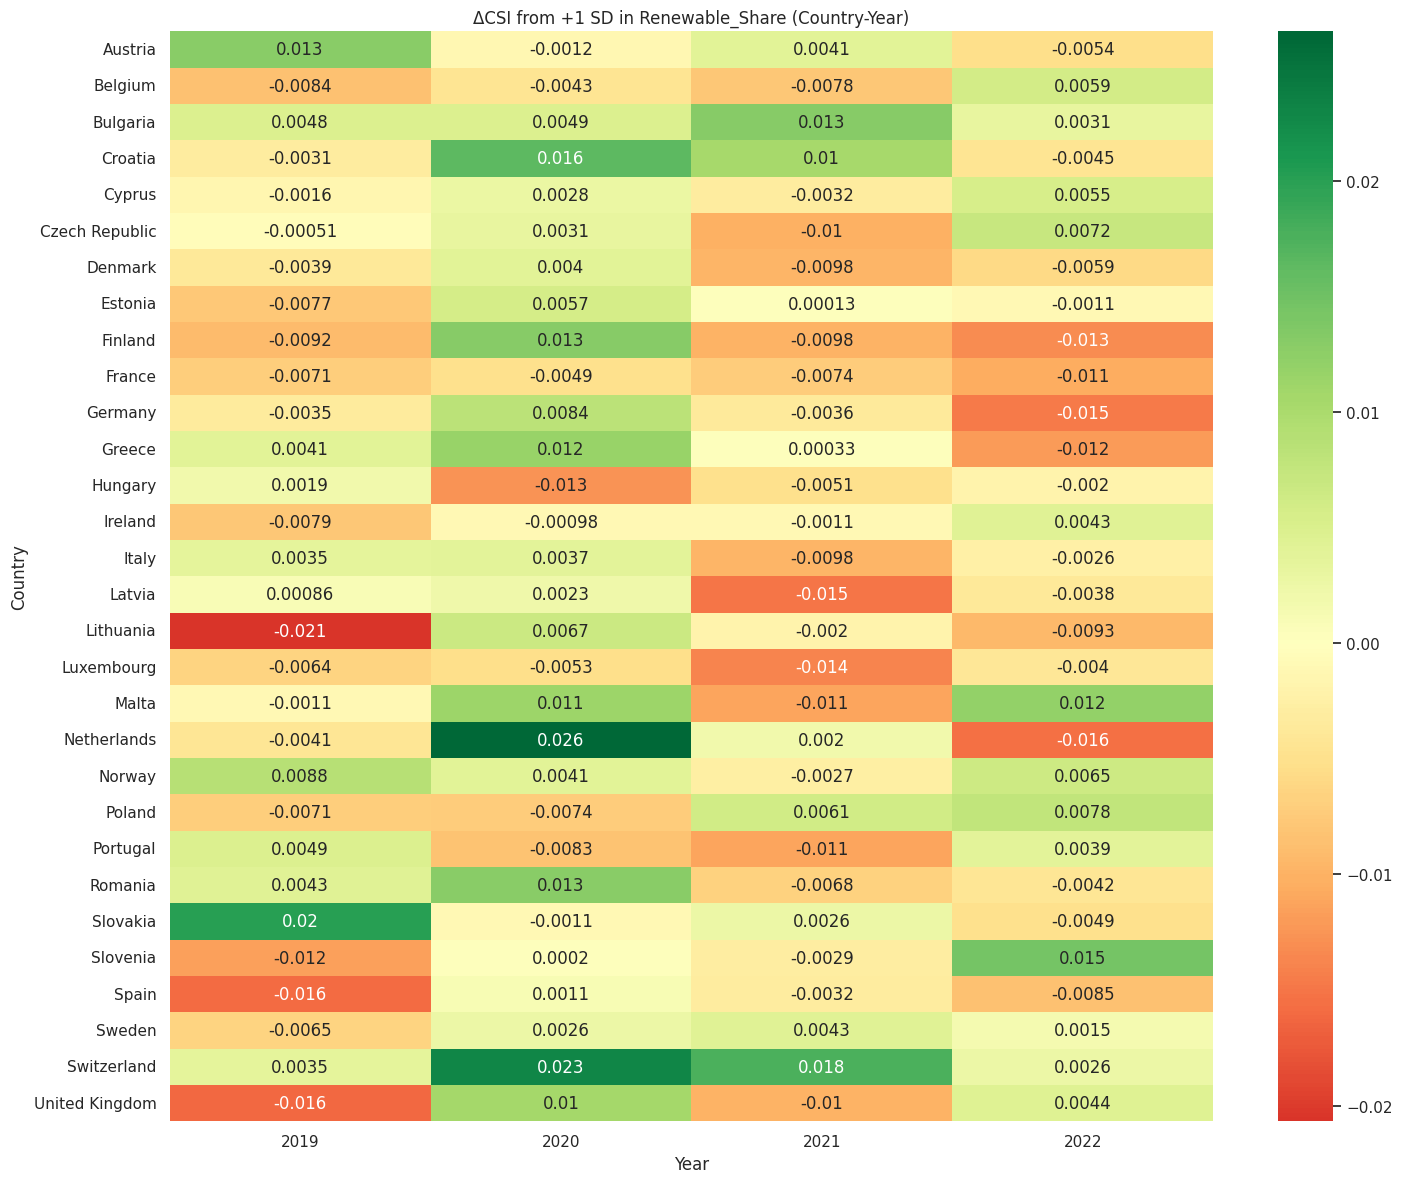

In [247]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.graph_objects as go
from copy import deepcopy

# ---------------------------------------------------
# INPUT: Change this line to switch SDG feature
feature_name = 'Renewable_Share'
# ---------------------------------------------------

# Step 1: Create a simulated input with +1 SD increase in the selected feature
X_sim = deepcopy(X_matrix)
feature_index = selected_features.index(feature_name)
X_sim[:, feature_index] += 1.0  # +1 SD increase

# Step 2: Sample posterior latent index Z using simulated inputs
lambda_samples = trace.posterior["lambda"].stack(sample=("chain", "draw")).values
Z_sim_list = []
for i in range(lambda_samples.shape[1]):
    lam = lambda_samples[:, i]
    Z_est = (X_sim @ lam) / (np.linalg.norm(lam)**2 + 1e-8)
    Z_sim_list.append(Z_est)
Z_sim_matrix = np.array(Z_sim_list)
Z_sim_mean = Z_sim_matrix.mean(axis=0)

# Step 3: Compare to original CSI
Z_original_mean = trace.posterior["Z"].mean(dim=["chain", "draw"]).values.flatten()
delta_matrix = Z_sim_matrix - Z_original_mean[None, :]  # shape: [n_sim, n_obs]

# Step 4: Extract meta info (Country, Year)
countries = df_model["Country"].values
years = df_model["Year"].values

# Step 5: Compute mean and 95% CI
delta_mean = delta_matrix.mean(axis=0)
delta_lower = np.percentile(delta_matrix, 2.5, axis=0)
delta_upper = np.percentile(delta_matrix, 97.5, axis=0)

# Step 6: Build summary DataFrame
delta_summary = pd.DataFrame({
    "Country": countries,
    "Year": years,
    "ΔCSI_mean": delta_mean.round(4),
    "95% CI Lower": delta_lower.round(4),
    "95% CI Upper": delta_upper.round(4)
})

def classify_significance(row):
    if row["95% CI Lower"] > 0:
        return "Certain Positive"
    elif row["95% CI Upper"] < 0:
        return "Certain Negative"
    else:
        return "Statistically Uncertain"

delta_summary["Significance"] = delta_summary.apply(classify_significance, axis=1)
delta_summary["ΔCSI (mean ± 95% CI)"] = delta_summary.apply(
    lambda row: f"{row['ΔCSI_mean']} [{row['95% CI Lower']}, {row['95% CI Upper']}]", axis=1
)
delta_summary_sorted = delta_summary.sort_values("ΔCSI_mean", ascending=False)

# Print Table Summary
print(delta_summary_sorted[[
    "Country", "Year", "ΔCSI_mean", "95% CI Lower", "95% CI Upper", "ΔCSI (mean ± 95% CI)"
]].to_string(index=False))

# Step 7: Aggregate by Country for global view
agg_by_country = delta_summary.groupby("Country").agg({
    "ΔCSI_mean": "mean",
    "95% CI Lower": "mean",
    "95% CI Upper": "mean"
}).reset_index()
agg_by_country["Significance"] = agg_by_country.apply(classify_significance, axis=1)
print("\nAggregated Impact by Country:\n")
print(agg_by_country.sort_values("ΔCSI_mean", ascending=False).to_string(index=False))

# Step 8: Heatmap of ΔCSI
df_model["Label"] = df_model["Country"] + " (" + df_model["Year"].astype(str) + ")"
df_model["CSI_Change"] = delta_mean
heatmap_data = df_model.pivot(index="Country", columns="Year", values="CSI_Change")
plt.figure(figsize=(15, 12))
sns.heatmap(heatmap_data, cmap="RdYlGn", center=0, annot=True)
plt.title(f"ΔCSI from +1 SD in {feature_name} (Country-Year)")
plt.ylabel("Country")
plt.xlabel("Year")
plt.tight_layout()
plt.show()

# Step 9: Top and Bottom 3 Plot with Annotations
selected_df = pd.concat([delta_summary_sorted.head(3), delta_summary_sorted.tail(3)])
selected_df["Label"] = selected_df["Country"] + " (" + selected_df["Year"].astype(str) + ")"

fig = go.Figure()
for _, row in selected_df.iterrows():
    label = row["Label"]
    mean = row["ΔCSI_mean"]
    lower = row["95% CI Lower"]
    upper = row["95% CI Upper"]

    fig.add_trace(go.Scatter(
        x=[mean],
        y=[label],
        mode='markers+text',
        marker=dict(size=10, color='green' if mean > 0 else 'red'),
        error_x=dict(
            type='data',
            symmetric=False,
            array=[upper - mean],
            arrayminus=[mean - lower],
            thickness=2,
            width=6,
            color='black'
        ),
        text=[f"{mean:.4f}"],
        textposition="top center",
        hovertemplate=(
            f"<b>{label}</b><br>"
            f"ΔCSI mean: {mean:.4f}<br>"
            f"95% CI: [{lower:.4f}, {upper:.4f}]<br>"
        ),
        showlegend=False
    ))

    fig.add_annotation(
        x=lower, y=label,
        text=f"{lower:.4f}",
        showarrow=False,
        xanchor="right",
        yanchor="middle",
        font=dict(size=10, color="gray")
    )
    fig.add_annotation(
        x=upper, y=label,
        text=f"{upper:.4f}",
        showarrow=False,
        xanchor="left",
        yanchor="middle",
        font=dict(size=10, color="gray")
    )

fig.add_vline(x=0, line_dash="dash", line_color="gray")
fig.update_layout(
    title=f"Top & Bottom 3 ΔCSI Values (95% CI) — +1 SD {feature_name}",
    xaxis_title="ΔCSI (mean ± 95% CI)",
    yaxis_title="Country-Year",
    yaxis=dict(autorange="reversed"),
    height=500,
    template="plotly_white",
    margin=dict(l=100, r=50, t=80, b=40),
)
fig.show()


In [248]:

choropleth_fig = px.choropleth(
    agg_by_country,
    locations="Country",  # This should be country names compatible with Plotly
    locationmode="country names",
    color="ΔCSI_mean",
    hover_name="Country",
    color_continuous_scale="RdYlGn",
    range_color=[agg_by_country["ΔCSI_mean"].min(), agg_by_country["ΔCSI_mean"].max()],
    title=f"Average ΔCSI by Country — +1 SD {feature_name}",
)

choropleth_fig.update_layout(
    geo=dict(scope = 'europe', showframe=False, showcoastlines=False),
    margin=dict(l=50, r=50, t=60, b=40),
    height=600
)

choropleth_fig.show()

## Climate Spending

       Country  Year  ΔCSI_mean  95% CI Lower  95% CI Upper      ΔCSI (mean ± 95% CI)
   Netherlands  2020     0.0275       -1.2595        1.3086  0.0275 [-1.2595, 1.3086]
   Switzerland  2020     0.0239       -0.8267        0.8725  0.0239 [-0.8267, 0.8725]
      Slovakia  2019     0.0211       -0.7650        0.8113   0.0211 [-0.765, 0.8113]
   Switzerland  2021     0.0186       -0.8744        0.9098  0.0186 [-0.8744, 0.9098]
       Croatia  2020     0.0176       -0.4392        0.4768  0.0176 [-0.4392, 0.4768]
      Slovenia  2022     0.0157       -0.2780        0.3058   0.0157 [-0.278, 0.3058]
       Finland  2020     0.0142       -0.2916        0.3186  0.0142 [-0.2916, 0.3186]
      Bulgaria  2021     0.0141       -0.4575        0.4868  0.0141 [-0.4575, 0.4868]
       Austria  2019     0.0140       -0.5732        0.5982   0.014 [-0.5732, 0.5982]
       Romania  2020     0.0139       -0.5528        0.5903  0.0139 [-0.5528, 0.5903]
         Malta  2022     0.0131       -1.1537        1

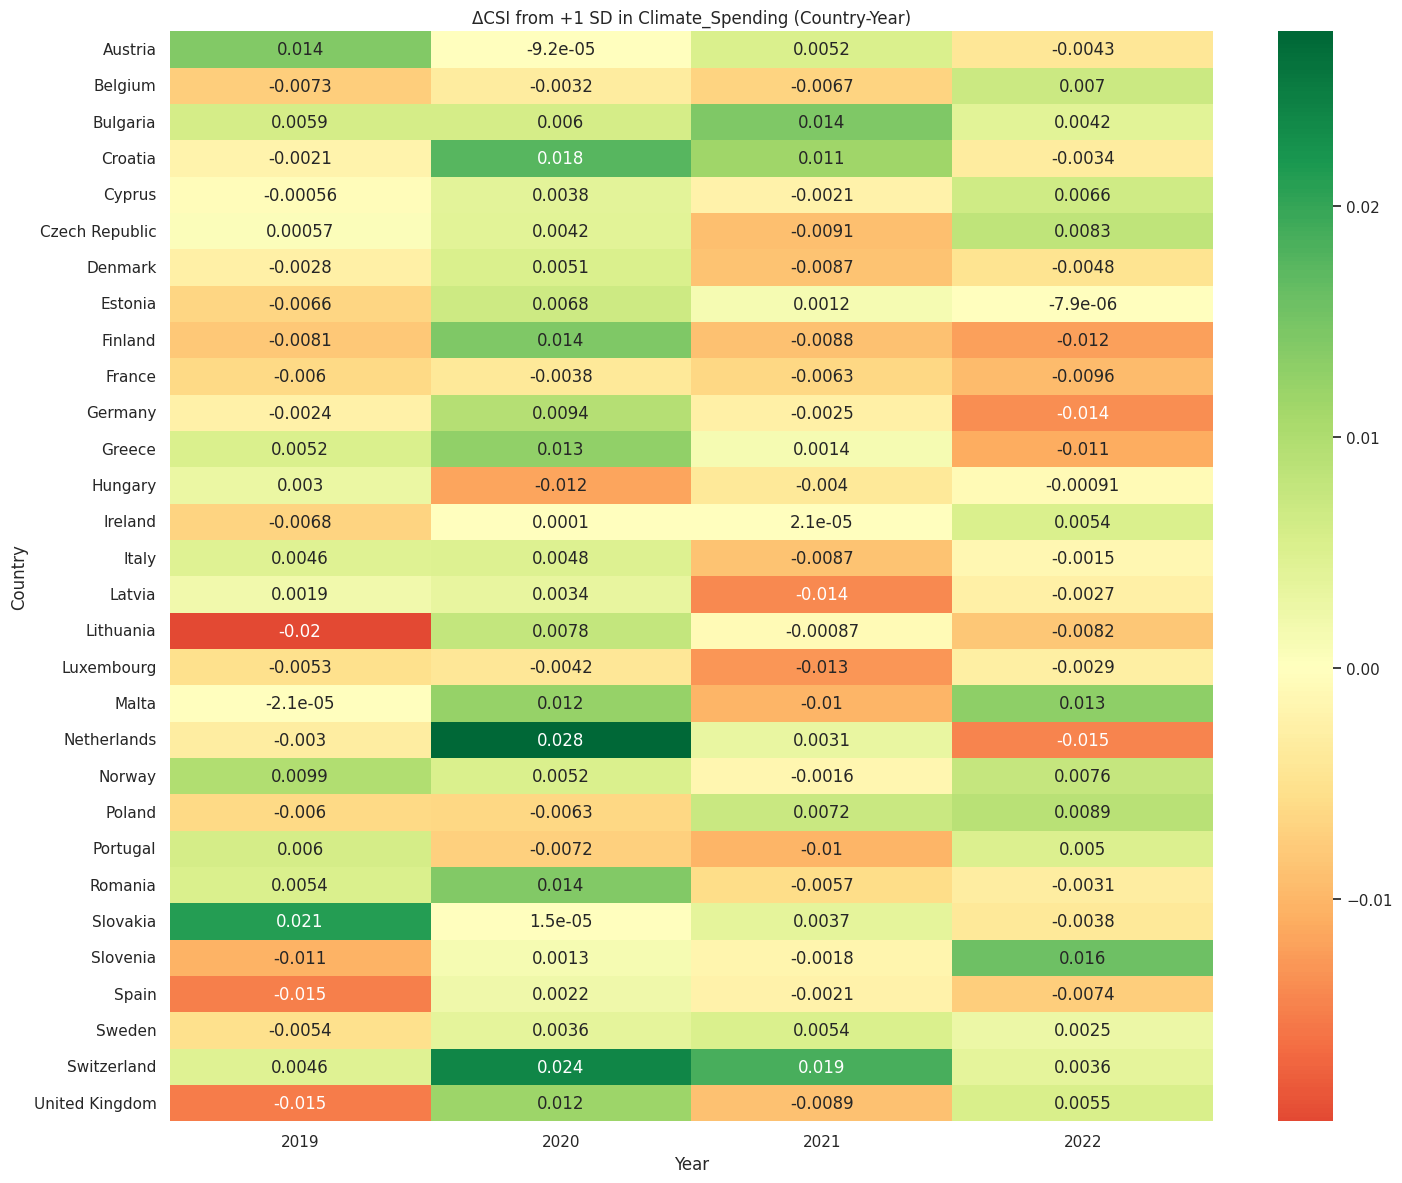

In [264]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.graph_objects as go
from copy import deepcopy

# ---------------------------------------------------
# INPUT: Change this line to switch SDG feature
feature_name = 'Climate_Spending'
# ---------------------------------------------------

# Step 1: Create a simulated input with +1 SD increase in the selected feature
X_sim = deepcopy(X_matrix)
feature_index = selected_features.index(feature_name)
X_sim[:, feature_index] += 1.0  # +1 SD increase

# Step 2: Sample posterior latent index Z using simulated inputs
lambda_samples = trace.posterior["lambda"].stack(sample=("chain", "draw")).values
Z_sim_list = []
for i in range(lambda_samples.shape[1]):
    lam = lambda_samples[:, i]
    Z_est = (X_sim @ lam) / (np.linalg.norm(lam)**2 + 1e-8)
    Z_sim_list.append(Z_est)
Z_sim_matrix = np.array(Z_sim_list)
Z_sim_mean = Z_sim_matrix.mean(axis=0)

# Step 3: Compare to original CSI
Z_original_mean = trace.posterior["Z"].mean(dim=["chain", "draw"]).values.flatten()
delta_matrix = Z_sim_matrix - Z_original_mean[None, :]  # shape: [n_sim, n_obs]

# Step 4: Extract meta info (Country, Year)
countries = df_model["Country"].values
years = df_model["Year"].values

# Step 5: Compute mean and 95% CI
delta_mean = delta_matrix.mean(axis=0)
delta_lower = np.percentile(delta_matrix, 2.5, axis=0)
delta_upper = np.percentile(delta_matrix, 97.5, axis=0)

# Step 6: Build summary DataFrame
delta_summary = pd.DataFrame({
    "Country": countries,
    "Year": years,
    "ΔCSI_mean": delta_mean.round(4),
    "95% CI Lower": delta_lower.round(4),
    "95% CI Upper": delta_upper.round(4)
})

def classify_significance(row):
    if row["95% CI Lower"] > 0:
        return "Certain Positive"
    elif row["95% CI Upper"] < 0:
        return "Certain Negative"
    else:
        return "Statistically Uncertain"

delta_summary["Significance"] = delta_summary.apply(classify_significance, axis=1)
delta_summary["ΔCSI (mean ± 95% CI)"] = delta_summary.apply(
    lambda row: f"{row['ΔCSI_mean']} [{row['95% CI Lower']}, {row['95% CI Upper']}]", axis=1
)
delta_summary_sorted = delta_summary.sort_values("ΔCSI_mean", ascending=False)

# Print Table Summary
print(delta_summary_sorted[[
    "Country", "Year", "ΔCSI_mean", "95% CI Lower", "95% CI Upper", "ΔCSI (mean ± 95% CI)"
]].to_string(index=False))

# Step 7: Aggregate by Country for global view
agg_by_country = delta_summary.groupby("Country").agg({
    "ΔCSI_mean": "mean",
    "95% CI Lower": "mean",
    "95% CI Upper": "mean"
}).reset_index()
agg_by_country["Significance"] = agg_by_country.apply(classify_significance, axis=1)
print("\nAggregated Impact by Country:\n")
print(agg_by_country.sort_values("ΔCSI_mean", ascending=False).to_string(index=False))

# Step 8: Heatmap of ΔCSI
df_model["Label"] = df_model["Country"] + " (" + df_model["Year"].astype(str) + ")"
df_model["CSI_Change"] = delta_mean
heatmap_data = df_model.pivot(index="Country", columns="Year", values="CSI_Change")
plt.figure(figsize=(15, 12))
sns.heatmap(heatmap_data, cmap="RdYlGn", center=0, annot=True)
plt.title(f"ΔCSI from +1 SD in {feature_name} (Country-Year)")
plt.ylabel("Country")
plt.xlabel("Year")
plt.tight_layout()
plt.show()

# Step 9: Top and Bottom 3 Plot with Annotations
selected_df = pd.concat([delta_summary_sorted.head(3), delta_summary_sorted.tail(3)])
selected_df["Label"] = selected_df["Country"] + " (" + selected_df["Year"].astype(str) + ")"

fig = go.Figure()
for _, row in selected_df.iterrows():
    label = row["Label"]
    mean = row["ΔCSI_mean"]
    lower = row["95% CI Lower"]
    upper = row["95% CI Upper"]

    fig.add_trace(go.Scatter(
        x=[mean],
        y=[label],
        mode='markers+text',
        marker=dict(size=10, color='green' if mean > 0 else 'red'),
        error_x=dict(
            type='data',
            symmetric=False,
            array=[upper - mean],
            arrayminus=[mean - lower],
            thickness=2,
            width=6,
            color='black'
        ),
        text=[f"{mean:.4f}"],
        textposition="top center",
        hovertemplate=(
            f"<b>{label}</b><br>"
            f"ΔCSI mean: {mean:.4f}<br>"
            f"95% CI: [{lower:.4f}, {upper:.4f}]<br>"
        ),
        showlegend=False
    ))

    fig.add_annotation(
        x=lower, y=label,
        text=f"{lower:.4f}",
        showarrow=False,
        xanchor="right",
        yanchor="middle",
        font=dict(size=10, color="gray")
    )
    fig.add_annotation(
        x=upper, y=label,
        text=f"{upper:.4f}",
        showarrow=False,
        xanchor="left",
        yanchor="middle",
        font=dict(size=10, color="gray")
    )

fig.add_vline(x=0, line_dash="dash", line_color="gray")
fig.update_layout(
    title=f"Top & Bottom 3 ΔCSI Values (95% CI) — +1 SD {feature_name}",
    xaxis_title="ΔCSI (mean ± 95% CI)",
    yaxis_title="Country-Year",
    yaxis=dict(autorange="reversed"),
    height=500,
    template="plotly_white",
    margin=dict(l=100, r=50, t=80, b=40),
)
fig.show()


In [265]:

choropleth_fig = px.choropleth(
    agg_by_country,
    locations="Country",  # This should be country names compatible with Plotly
    locationmode="country names",
    color="ΔCSI_mean",
    hover_name="Country",
    color_continuous_scale="RdYlGn",
    range_color=[agg_by_country["ΔCSI_mean"].min(), agg_by_country["ΔCSI_mean"].max()],
    title=f"Average ΔCSI by Country — +1 SD {feature_name}",
)

choropleth_fig.update_layout(
    geo=dict(scope = 'europe', showframe=False, showcoastlines=False),
    margin=dict(l=50, r=50, t=60, b=40),
    height=600
)

choropleth_fig.show()

## Impact of ±1 SD Changes in SDG Features on CSI

In [251]:
import pandas as pd
import numpy as np
import plotly.express as px

# Simulate dataset structure
sdg_features = [
    'Energy_consumption', 'Renewable_Share', 'GDP_Capita',
    'Passenger_transport', 'Air_emission_intensity',
    'Grossvalue_Egoods', 'Climate_Losses', 'Climate_Spending', 'Green_Bonds'
]

# Assume df_model has Country and Year
countries = df_model["Country"].values
years = df_model["Year"].values
original_mean = Z_original_mean

records = []
for feature in sdg_features:
    Z_sim_plus = simulate_ppc(X_base, lambda_samples, selected_features, feature, delta=3.0)
    delta_plus = Z_sim_plus - original_mean

    for idx, d in enumerate(delta_plus):
        records.append({
            "Country-Year": f"{countries[idx]} ({years[idx]})",
            "ΔCSI": d,
            "Feature": feature
        })

delta_df = pd.DataFrame(records)

# Create a plotly heatmap style strip for feature impact
fig = px.strip(
    delta_df,
    x="ΔCSI",
    y="Feature",
    hover_name="Country-Year",
    orientation="h",
    color="Feature",
    title="Country-wise ΔCSI due to +1 SD Change in SDG Features",
    stripmode='group'
)
fig.update_layout(height=600)
fig.show()


In [252]:
import plotly.express as px
import pandas as pd

# Simulate a long-form DataFrame for multi-feature delta visualization
records = []
for feature in sdg_features:
    Z_sim_plus = simulate_ppc(X_base, lambda_samples, selected_features, feature, delta=3.0)
    Z_sim_minus = simulate_ppc(X_base, lambda_samples, selected_features, feature, delta=-3.0)

    delta_plus = Z_sim_plus - Z_original_mean
    delta_minus = Z_sim_minus - Z_original_mean

    for idx, d in enumerate(delta_plus):
        records.append({"Index": idx, "ΔCSI": d, "Feature": feature, "Shift": "+1 SD"})
    for idx, d in enumerate(delta_minus):
        records.append({"Index": idx, "ΔCSI": d, "Feature": feature, "Shift": "-1 SD"})

delta_df = pd.DataFrame(records)

# Plot
fig = px.line(
    delta_df,
    x="Index",
    y="ΔCSI",
    color="Shift",
    facet_col="Feature",
    facet_col_wrap=3,
    title="Impact of ±1 SD Changes in SDG Features on CSI",
    markers=True
)
fig.update_layout(height=1000)
fig.show()


In [253]:
import plotly.express as px

# Create boxplot comparing ±1 SD shifts for each SDG feature
fig = px.box(
    delta_df,
    x="Feature",
    y="ΔCSI",
    color="Shift",
    title="Distribution of ΔCSI by ±1 SD Change in SDG Features",
    points="all",  # show all data points
    color_discrete_map={"+1 SD": "green", "-1 SD": "red"}
)

fig.update_layout(
    xaxis_title="SDG Feature",
    yaxis_title="ΔCSI",
    boxmode="group",
    height=600,
)
fig.show()


In [254]:
fig = px.violin(
    delta_df,
    x="Feature",
    y="ΔCSI",
    color="Shift",
    box=True,
    points="all",
    title="Impact of ±1 SD Shifts in SDG Features on CSI Distribution",
    color_discrete_map={"+1 SD": "green", "-1 SD": "red"}
)
fig.update_layout(height=600)
fig.show()


In [255]:
# Aggregate ΔCSI per feature and shift
summary = delta_df.groupby(["Feature", "Shift"]).agg(
    mean_dCSI=("ΔCSI", "mean"),
    lower=("ΔCSI", lambda x: np.percentile(x, 2.5)),
    upper=("ΔCSI", lambda x: np.percentile(x, 97.5))
).reset_index()

# Compute error bars
summary["error_low"] = summary["mean_dCSI"] - summary["lower"]
summary["error_high"] = summary["upper"] - summary["mean_dCSI"]

# Plot
fig = px.bar(
    summary,
    x="Feature",
    y="mean_dCSI",
    color="Shift",
    error_y="error_high",
    error_y_minus="error_low",
    barmode="group",
    title="Average ΔCSI per Feature (±1 SD Shift) with 95% CI",
    labels={"mean_dCSI": "Average ΔCSI"},
    color_discrete_map={"+1 SD": "green", "-1 SD": "red"}
)
fig.update_layout(xaxis_tickangle=-45, height=600)
fig.show()


In [256]:
# Pivot to create Feature × Shift heatmap
heatmap_data = summary.pivot(index="Feature", columns="Shift", values="mean_dCSI")
fig = px.imshow(
    heatmap_data,
    color_continuous_scale="RdYlGn",
    text_auto=".3f",
    title="Mean ΔCSI by Feature and ±1 SD Shift"
)
fig.update_layout(height=500)
fig.show()


In [257]:
# For radar chart, we need wide format per shift
radar_df = summary.pivot(index="Feature", columns="Shift", values="mean_dCSI").reset_index()

fig = go.Figure()
fig.add_trace(go.Scatterpolar(
    r=radar_df["+1 SD"],
    theta=radar_df["Feature"],
    fill='toself',
    name='+1 SD',
    line=dict(color='green')
))
fig.add_trace(go.Scatterpolar(
    r=radar_df["-1 SD"],
    theta=radar_df["Feature"],
    fill='toself',
    name='-1 SD',
    line=dict(color='red')
))

fig.update_layout(
    polar=dict(radialaxis=dict(visible=True)),
    title="ΔCSI per Feature (±1 SD) — Radar View",
    height=600,
    showlegend=True
)
fig.show()


#Simulate ±1, ±2, ±3 SD for All SDG Features

In [258]:
delta_records = []
sd_shifts = [-3, -2, -1, 0, 1, 2, 3]

for feature in selected_features:
    feature_idx = selected_features.index(feature)

    for delta in sd_shifts:
        # Step 1: simulate +delta SD shift in selected feature
        X_sim = deepcopy(X_base)
        X_sim[:, feature_idx] += delta

        Z_sim_list = []
        for i in range(lambda_samples.shape[1]):
            lam = lambda_samples[:, i]
            Z_est = (X_sim @ lam) / (np.linalg.norm(lam)**2 + 1e-8)
            Z_sim_list.append(Z_est)

        Z_sim_matrix = np.array(Z_sim_list)
        delta_csi = Z_sim_matrix.mean(axis=0) - Z_original_mean

        # Step 2: record mean and CI across country-years
        mean_delta = delta_csi.mean()
        lower = np.percentile(delta_csi, 2.5)
        upper = np.percentile(delta_csi, 97.5)

        delta_records.append({
            "Feature": feature,
            "SD_Shift": delta,
            "ΔCSI_mean": mean_delta,
            "95% CI Lower": lower,
            "95% CI Upper": upper
        })

# Final dataframe
multi_sd_df = pd.DataFrame(delta_records)


In [259]:
import plotly.express as px

fig = px.line(
    multi_sd_df,
    x="SD_Shift",
    y="ΔCSI_mean",
    color="Feature",
    markers=True,
    title="Effect of SDG Features on CSI across ±3 SD",
    labels={"SD_Shift": "SD Deviation", "ΔCSI_mean": "Mean ΔCSI"},
)
fig.add_hline(y=0, line_dash="dash", line_color="gray")
fig.update_layout(height=600)
fig.show()


In [260]:
heatmap_df = multi_sd_df.pivot(index="Feature", columns="SD_Shift", values="ΔCSI_mean")

fig = px.imshow(
    heatmap_df,
    text_auto=".3f",
    color_continuous_scale="RdYlGn",
    title="Mean ΔCSI by Feature and ±3 SD Shifts"
)
fig.update_layout(height=600)
fig.show()
